Importing the libraries

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import time
import scipy.stats

from IPython.core.debugger import set_trace
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
np.random.seed(108)

# **1- KNN and DT on Hepatitis Dataset**

# Exploratory Data Analysis

## Importing the first dataset

Fetch the dataset from UCI repository
http://archive.ics.uci.edu/ml/datasets/Hepatitis

In [2]:
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo

# fetch dataset
hepatitis = fetch_ucirepo(id=46)

# metadata
print(hepatitis.metadata)

# variable information
print(hepatitis.variables)

{'uci_id': 46, 'name': 'Hepatitis', 'repository_url': 'https://archive.ics.uci.edu/dataset/46/hepatitis', 'data_url': 'https://archive.ics.uci.edu/static/public/46/data.csv', 'abstract': 'From G.Gong: CMU; Mostly Boolean or numeric-valued attribute types; Includes cost data (donated by Peter Turney)', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 155, 'num_features': 19, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1983, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5Q59J', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'Please ask Gail Gong for further information on this database.', 'purpose': None, 'funded_by': None, 'instances_represent': None, 'recommended_data_splits': None, 'sensitive_data': None, 'preprocessing_descri

## Removing missing values

In [3]:
# data (as pandas dataframes)
X = hepatitis.data.features
y = hepatitis.data.targets
XY = pd.concat([X, y], axis = 1)
XY.head()

,Age,Sex,Steroid,Antivirals,Fatigue,Malaise,Anorexia,Liver Big,Liver Firm,Spleen Palpable,Spiders,Ascites,Varices,Bilirubin,Alk Phosphate,Sgot,Albumin,Protime,Histology,Class
0,30,2,1.0,2,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,85.0,18.0,4.0,NaN,1,2
1,50,1,1.0,2,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,0.9,135.0,42.0,3.5,NaN,1,2
2,78,1,2.0,2,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.7,96.0,32.0,4.0,NaN,1,2
3,31,1,NaN,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.7,46.0,52.0,4.0,80.0,1,2
4,34,1,2.0,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,NaN,200.0,4.0,NaN,1,2


In [4]:
#Check the number of missing values for each feature
XY.isnull().sum()

,0
Age,0
Sex,0
Steroid,1
Antivirals,0
Fatigue,1
Malaise,1
Anorexia,1
Liver Big,10
Liver Firm,11
Spleen Palpable,5


In [5]:
#Drop the missing values and reset the index of the rows
XY = XY.dropna().reset_index(drop = True)

XY.head(10)

,Age,Sex,Steroid,Antivirals,Fatigue,Malaise,Anorexia,Liver Big,Liver Firm,Spleen Palpable,Spiders,Ascites,Varices,Bilirubin,Alk Phosphate,Sgot,Albumin,Protime,Histology,Class
0,34,1,2.0,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.9,95.0,28.0,4.0,75.0,1,2
1,39,1,1.0,1,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.3,78.0,30.0,4.4,85.0,1,2
2,32,1,2.0,1,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,59.0,249.0,3.7,54.0,1,2
3,41,1,2.0,1,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,0.9,81.0,60.0,3.9,52.0,1,2
4,30,1,2.0,2,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.2,57.0,144.0,4.9,78.0,1,2
5,38,1,1.0,2,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,72.0,89.0,2.9,46.0,1,2
6,40,1,1.0,2,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,0.6,62.0,166.0,4.0,63.0,1,2
7,38,1,2.0,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.7,53.0,42.0,4.1,85.0,2,2
8,38,1,1.0,1,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,0.7,70.0,28.0,4.2,62.0,1,2
9,22,2,2.0,1,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.9,48.0,20.0,4.2,64.0,1,2


## Correlation of features with target

How does the data correlate with the target 'class' data?

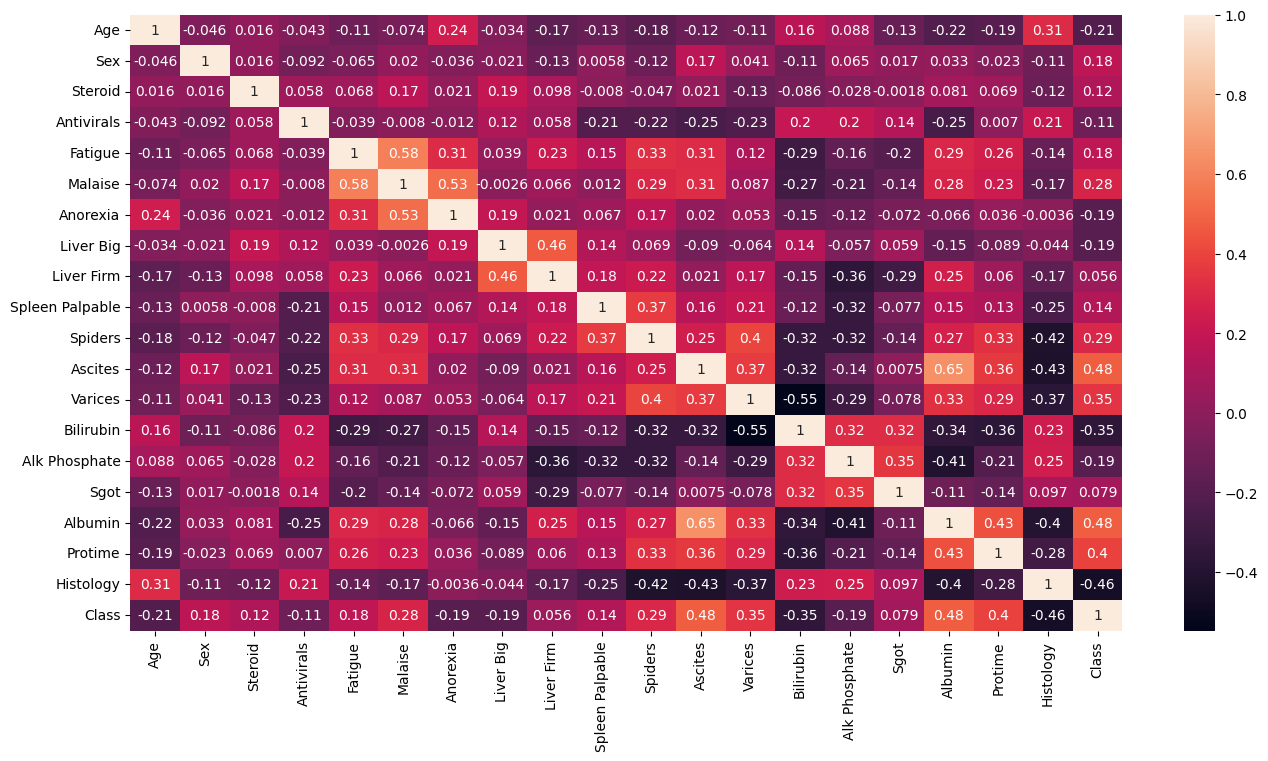

In [6]:
plt.figure(figsize = (16,8))
sns.heatmap(XY.corr(), annot=True)
plt.show()

## Organizing the binary values

Modify the binary values from (1,2) to (0,1)

In [7]:
XY = XY.replace(1,0)
XY = XY.replace(2,1)

XY.head(10)

,Age,Sex,Steroid,Antivirals,Fatigue,Malaise,Anorexia,Liver Big,Liver Firm,Spleen Palpable,Spiders,Ascites,Varices,Bilirubin,Alk Phosphate,Sgot,Albumin,Protime,Histology,Class
0,34,0,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.9,95.0,28.0,4.0,75.0,0,1
1,39,0,0.0,0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.3,78.0,30.0,4.4,85.0,0,1
2,32,0,1.0,0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,59.0,249.0,3.7,54.0,0,1
3,41,0,1.0,0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.9,81.0,60.0,3.9,52.0,0,1
4,30,0,1.0,1,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2.2,57.0,144.0,4.9,78.0,0,1
5,38,0,0.0,1,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,72.0,89.0,2.9,46.0,0,1
6,40,0,0.0,1,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.6,62.0,166.0,4.0,63.0,0,1
7,38,0,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.7,53.0,42.0,4.1,85.0,1,1
8,38,0,0.0,0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.7,70.0,28.0,4.2,62.0,0,1
9,22,1,1.0,0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.9,48.0,20.0,4.2,64.0,0,1


## Data basic stats and distributions

Compute basic statistics and the distributions of the features and the target data.

In [8]:
XY.describe()

,Age,Sex,Steroid,Antivirals,Fatigue,Malaise,Anorexia,Liver Big,Liver Firm,Spleen Palpable,Spiders,Ascites,Varices,Bilirubin,Alk Phosphate,Sgot,Albumin,Protime,Histology,Class
count,80.00000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.00000,80.000000
mean,40.66250,0.137500,0.525000,0.737500,0.350000,0.612500,0.850000,0.837500,0.525000,0.812500,0.687500,0.850000,0.875000,0.996250,102.912500,82.025000,3.843750,62.512500,0.41250,0.837500
std,11.28003,0.346547,0.502525,0.442769,0.479979,0.490253,0.359324,0.371236,0.502525,0.392775,0.466437,0.359324,0.332805,0.996379,53.684779,71.599974,0.576292,23.427774,0.49539,0.371236
min,20.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000,14.000000,2.100000,0.000000,0.00000,0.000000
25%,32.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.500000,68.250000,30.750000,3.500000,46.000000,0.00000,1.000000
50%,38.50000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.700000,85.000000,56.500000,4.000000,62.000000,0.00000,1.000000
75%,49.25000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.300000,133.500000,102.750000,4.200000,77.250000,1.00000,1.000000
max,72.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.800000,280.000000,420.000000,5.000000,100.000000,1.00000,1.000000


### Distribution of the target

<ipython-input-9-5a8d1afe5b25>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  class_count = sns.countplot(x="Class", data = XY, palette=["orange", "blue"])
<ipython-input-9-5a8d1afe5b25>:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Death','Alive']);


Text(0.5, 1.0, 'Count of Outcome')

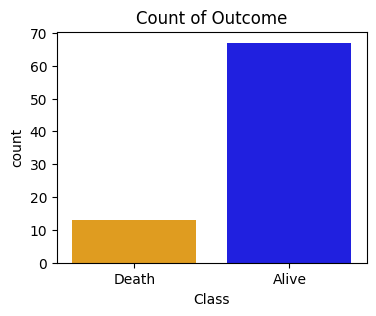

In [9]:
plt.figure(figsize=(4, 3))
class_count = sns.countplot(x="Class", data = XY, palette=["orange", "blue"])
plt.gca().set_xticklabels(['Death','Alive']);
class_count.set_title("Count of Outcome")

Note from the figure above that the target or outcome is unbalanced

### Distribution of continuous features

<ipython-input-10-f07a1e95c9f0>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  XY[['Age','Bilirubin','Alk Phosphate','Sgot','Albumin','Protime']].hist(ax = ax)


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Bilirubin'}>],
       [<Axes: title={'center': 'Alk Phosphate'}>,
        <Axes: title={'center': 'Sgot'}>],
       [<Axes: title={'center': 'Albumin'}>,
        <Axes: title={'center': 'Protime'}>]], dtype=object)

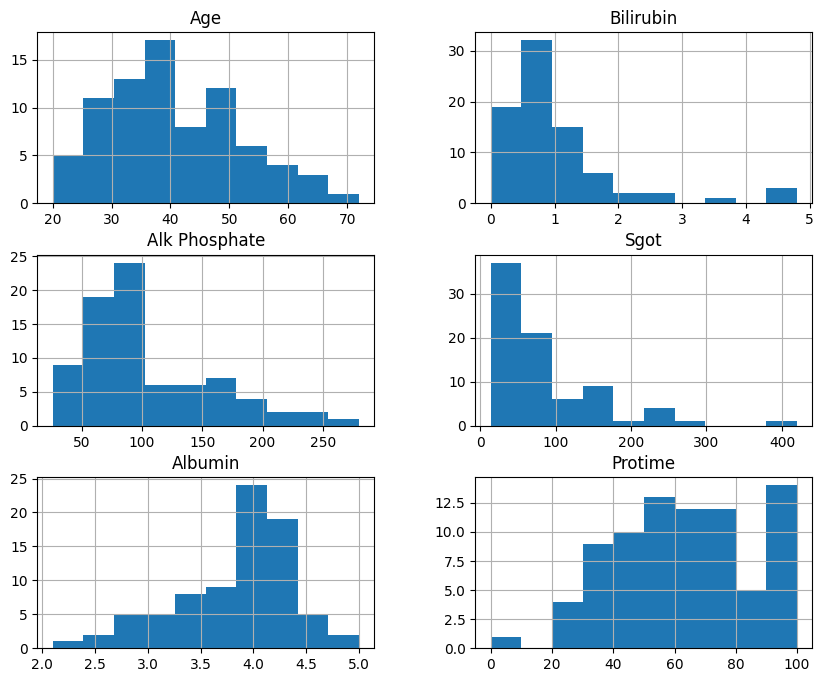

In [10]:
fig = plt.figure(figsize = (10,8))
ax = fig.gca()
XY[['Age','Bilirubin','Alk Phosphate','Sgot','Albumin','Protime']].hist(ax = ax)

### Distribution of categorical features

<ipython-input-11-3d3c37751d37>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  XY[['Sex','Steroid','Antivirals','Fatigue','Malaise','Anorexia','Liver Big','Liver Firm','Spleen Palpable','Spiders','Ascites','Varices','Histology']].hist(ax = ax)


array([[<Axes: title={'center': 'Sex'}>,
        <Axes: title={'center': 'Steroid'}>,
        <Axes: title={'center': 'Antivirals'}>,
        <Axes: title={'center': 'Fatigue'}>],
       [<Axes: title={'center': 'Malaise'}>,
        <Axes: title={'center': 'Anorexia'}>,
        <Axes: title={'center': 'Liver Big'}>,
        <Axes: title={'center': 'Liver Firm'}>],
       [<Axes: title={'center': 'Spleen Palpable'}>,
        <Axes: title={'center': 'Spiders'}>,
        <Axes: title={'center': 'Ascites'}>,
        <Axes: title={'center': 'Varices'}>],
       [<Axes: title={'center': 'Histology'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

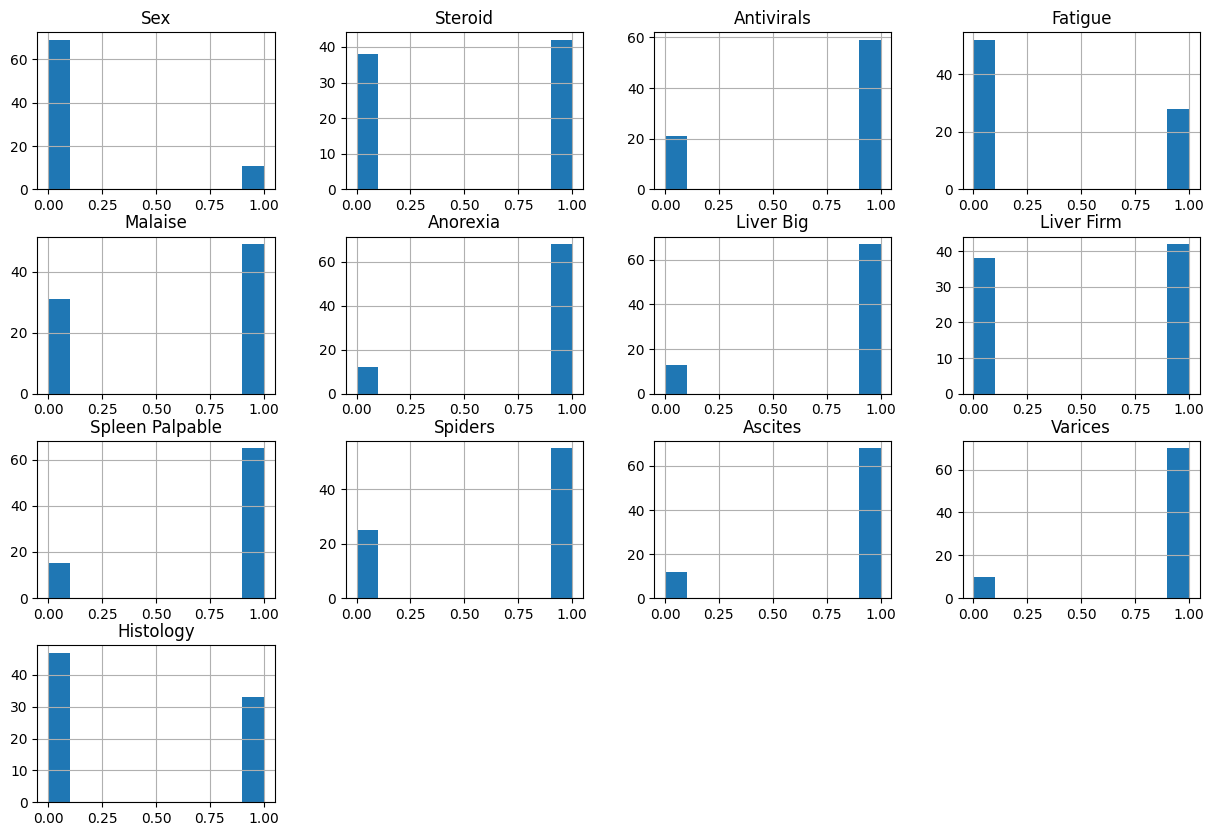

In [11]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
XY[['Sex','Steroid','Antivirals','Fatigue','Malaise','Anorexia','Liver Big','Liver Firm','Spleen Palpable','Spiders','Ascites','Varices','Histology']].hist(ax = ax)

## Feature importance using statistical analysis

KNN model doesn't automatically decide which features are the most important.
I test the feature importance with the binary target data using:
- ANOVA test for the numerical features
- Chi-square test for the categorical features

### Feature importance using ANOVA test

In [12]:
from scipy.stats import f_oneway

Columns = ['Age', 'Bilirubin', 'Alk Phosphate', 'Sgot', 'Albumin', 'Protime']
XY_clean = XY.dropna(subset=Columns + ['Class'])

for column in Columns:
    groups = XY_clean.groupby('Class')[column].apply(list)

    # Check we have at least two groups with more than 1 value
    if len(groups) >= 2 and all(len(g) > 1 for g in groups):
        anova = f_oneway(*groups)
        print(f"{column} - F-statistic: {anova.statistic:.4f}")
        print(f"{column} - P-Value: {anova.pvalue:.4f}")
    else:
        print(f"{column} - Not enough data for ANOVA")
    print()

Age - F-statistic: 3.6985
Age - P-Value: 0.0581

Bilirubin - F-statistic: 10.2266
Bilirubin - P-Value: 0.0020

Alk Phosphate - F-statistic: 2.9009
Alk Phosphate - P-Value: 0.0925

Sgot - F-statistic: 0.4865
Sgot - P-Value: 0.4876

Albumin - F-statistic: 23.0251
Albumin - P-Value: 0.0000

Protime - F-statistic: 14.4532
Protime - P-Value: 0.0003



From the above results, the most important features are the ones with the highest F-Statistic; so, the best 3 in descending order are: Albumin, Protime and Bilirubin.

### Feature importance using Chi² test

In [13]:
from scipy.stats import chi2_contingency

Columns = ['Sex', 'Steroid', 'Antivirals', 'Fatigue', 'Malaise', 'Anorexia',
           'Liver Big', 'Liver Firm', 'Spleen Palpable', 'Spiders',
           'Ascites', 'Varices', 'Histology']

for column in Columns:
    # Drop rows with NaNs in the current column or 'Class'
    data_clean = XY.dropna(subset=[column, 'Class'])

    # Create contingency table
    table = pd.crosstab(data_clean['Class'], data_clean[column])

    # Check for valid shape
    if table.shape[0] >= 2 and table.shape[1] >= 2:
        chi2_stat, p_value, dof, expected = chi2_contingency(table)
        print(f"{column} - Chi\u00b2 statistic: {chi2_stat:.4f}")
        print(f"{column} - P-Value: {p_value:.4f}")
    else:
        print(f"{column} - Not enough data for Chi-square test")
    print()


Sex - Chi² statistic: 1.2838
Sex - P-Value: 0.2572

Steroid - Chi² statistic: 0.6466
Steroid - P-Value: 0.4213

Antivirals - Chi² statistic: 0.3950
Antivirals - P-Value: 0.5297

Fatigue - Chi² statistic: 1.6967
Fatigue - P-Value: 0.1927

Malaise - Chi² statistic: 4.6395
Malaise - P-Value: 0.0312

Anorexia - Chi² statistic: 1.5146
Anorexia - P-Value: 0.2184

Liver Big - Chi² statistic: 1.7548
Liver Big - P-Value: 0.1853

Liver Firm - Chi² statistic: 0.0389
Liver Firm - P-Value: 0.8436

Spleen Palpable - Chi² statistic: 0.6806
Spleen Palpable - P-Value: 0.4094

Spiders - Chi² statistic: 5.0517
Spiders - P-Value: 0.0246

Ascites - Chi² statistic: 14.9137
Ascites - P-Value: 0.0001

Varices - Chi² statistic: 6.9411
Varices - P-Value: 0.0084

Histology - Chi² statistic: 14.2765
Histology - P-Value: 0.0002



From the above results, the most important features are the ones with the smallest p-values; so, the most important ones in descending order are: Ascites and Histology.

# Implementing KNN

From the correlation matrix and the Anova and Chi² tests, I took the five best numerical and categorical features Albumin, Protime and Bilirubin for classification.

Prepar the dataset

In [14]:
x = XY[['Albumin','Protime', 'Bilirubin', 'Ascites', 'Histology']]
y = XY['Class']

#print the feature shape and classes of dataset
(N,D), C = x.shape, np.max(y)+1
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')


instances (N) 	 80 
 features (D) 	 5 
 classes (C) 	 2


## Train Test Split

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 108, stratify=y)

## Cross-Validation to find the hyperparameter K

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#scale features (KNN is distance-based and benefits from scaling)
scaler = StandardScaler()
knn = KNeighborsClassifier()

# Define a pipeline: scaling + KNN
pipeline = Pipeline([
    ('scaler', scaler),
    ('knn', knn)
])

# Range of k values to test
param_grid = {'knn__n_neighbors': list(range(1, 16))}

# GridSearchCV with 4-fold cross-validation
grid = GridSearchCV(pipeline, param_grid, cv=4, scoring='accuracy')
grid.fit(x_train, y_train)

# Best result
print("Best k:", grid.best_params_['knn__n_neighbors'])
print("Best cross-validated accuracy:", grid.best_score_)

Best k: 5
Best cross-validated accuracy: 0.859375


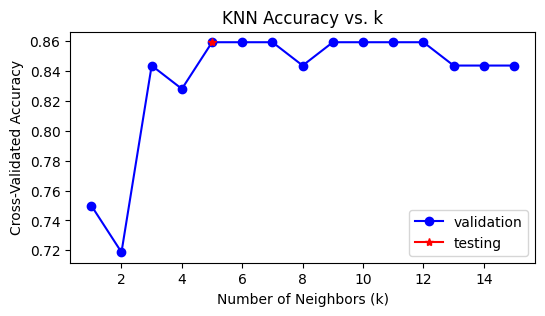

In [17]:
# Extract values of k and corresponding mean test scores
k_values = [param['knn__n_neighbors'] for param in grid.cv_results_['params']]
accuracies = grid.cv_results_['mean_test_score']

# Plot
plt.figure(figsize=(6, 3))
plt.plot(k_values, accuracies, marker='o', color='blue', label='validation')
plt.plot(grid.best_params_['knn__n_neighbors'], grid.best_score_, marker='*', color='red', label='testing')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN Accuracy vs. k')
plt.legend(loc='best')
plt.show()

## Standardization

In [18]:
#scale features (KNN is distance-based and benefits from scaling)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

## Testing KNN model with the best k

In [19]:
KNN = KNeighborsClassifier(n_neighbors = grid.best_params_['knn__n_neighbors'])
KNN.fit(x_train, y_train)
KNN.predict(x_test)
KNN.score(x_test, y_test)

0.8125

So, the best KNN model found is k = 5 with 5 selected features.

# Implementing Decision Tree (DT)

Prepare the dataset

In [20]:
x = XY[['Albumin','Protime','Bilirubin','Ascites','Histology']] #, , ,
y = XY['Class']

#print the feature shape and classes of dataset
(N,D), C = x.shape, np.max(y)+1
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')


instances (N) 	 80 
 features (D) 	 5 
 classes (C) 	 2


## Train Test Split

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 108, stratify=y)

## Cross-Validation to find the hyperparameter max depth

In [28]:
from sklearn.tree import DecisionTreeClassifier

# 1. Define the model
dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 108)

# 2. Define the range of tree depths to test
param_grid = {'max_depth': list(range(1, 9))}

# 3. Run GridSearchCV with accuracy scoring and 3-fold CV
grid = GridSearchCV(dt, param_grid, cv=4, scoring='accuracy')
grid.fit(x_train, y_train)

# 4. Best depth and best accuracy
print("Best depth:", grid.best_params_['max_depth'])
print("Best cross-validated accuracy:", grid.best_score_)


Best depth: 3
Best cross-validated accuracy: 0.859375


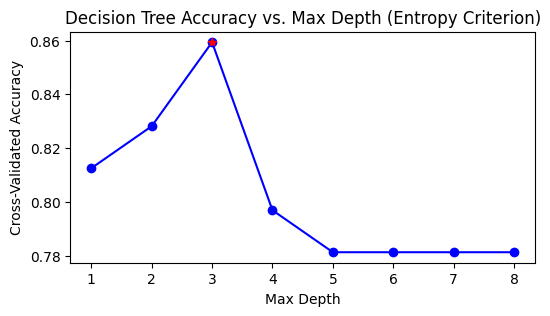

In [29]:
# Extract results
depths = [d['max_depth'] for d in grid.cv_results_['params']]
accuracies = grid.cv_results_['mean_test_score']

# Plot
plt.figure(figsize=(6, 3))
plt.plot(depths, accuracies, marker='o', color='blue', label='validation')
plt.plot(grid.best_params_['max_depth'], grid.best_score_, marker='*', color='red', label='testing')
plt.xlabel('Max Depth')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Decision Tree Accuracy vs. Max Depth (Entropy Criterion)')
plt.show()


## Testing DT model with the best max depth

In [30]:
DT = DecisionTreeClassifier(criterion = 'entropy', max_depth = grid.best_params_['max_depth'], random_state = 108)
DT.fit(x_train, y_train)
DT.predict(x_test)
DT.score(x_test, y_test)

1.0

# Compareing the models with ROC & PRC curves

From the EDA, we know that the target labels are unbalanced toward the positive class. Therefore, PRC is a better choice to compare the results than ROC.

In [59]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc, RocCurveDisplay, PrecisionRecallDisplay

# Random (baseline) classifier
RND = DummyClassifier(strategy = 'uniform')
RND.fit(x_train, y_train)

KNN = KNeighborsClassifier(n_neighbors = 5)
KNN.fit(x_train, y_train)

DT = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3)
DT.fit(x_train, y_train)

# Probabilities for the positive class (label 1)
KNN_probs = KNN.predict_proba(x_test)[:, 1]
DT_probs = DT.predict_proba(x_test)[:, 1]
RND_probs = RND.predict_proba(x_test)[:, 1]
print(KNN_probs)
print(DT_probs)
print(RND_probs)



[1.  0.6 0.8 1.  0.6 1.  0.6 0.8 1.  0.8 1.  1.  1.  0.2 0.2 0.8]
[0.75  0.125 0.75  1.    1.    1.    1.    1.    1.    1.    0.75  1.
 1.    0.125 0.125 0.75 ]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


## ROC for KNN, DT and Random calssifiers

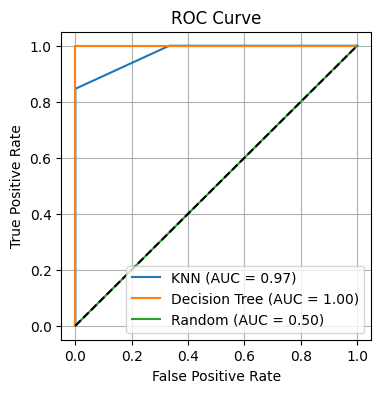

In [60]:
plt.figure(figsize=(4, 4))

for name, probs in zip(['KNN', 'Decision Tree', 'Random'],
                       [KNN_probs, DT_probs, RND_probs]):
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    del roc_auc

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


## PRC for KNN, DT and Random calssifiers

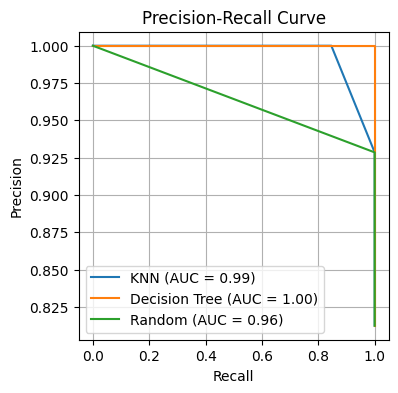

In [56]:
RND = DummyClassifier(strategy='stratified')  # predicts based on class distribution
RND.fit(x_train, y_train)
RND_probs = RND.predict_proba(x_test)[:, 1]

plt.figure(figsize=(4, 4))

for name, probs in zip(['KNN', 'Decision Tree', 'Random'],
                       [KNN_probs, DT_probs, RND_probs]):
    precision, recall, _ = precision_recall_curve(y_test, probs)
    prc_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{name} (AUC = {prc_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


